# The Multi-Armed Bandit 

Slot machine with multiple levers (arms). Each arm has a different payout and payout probability. Goal: Find best lever to maximize return.

In [2]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
class BanditEnv():
    def __init__(self, payout_list, reward_list):
        # payout_list: list of probabilities of payouts for each arm
        # reward_list: reward for each arm
        self.payout_list = payout_list
        self.reward_list = reward_list
    
    def step(self, action):
        # Random likelihood of being rewarded
        if torch.rand(1).item() < self.payout_list[action]:
            return self.reward_list[action]
        return 0

In [3]:
bandit_payout = [0.1, 0.15, 0.3]
bandit_reward = [4, 3, 1]
bandit_env = BanditEnv(bandit_payout, bandit_reward)

In [29]:
num_episodes = 10000
num_actions = len(bandit_payout)
action_count = [0 for i in range(num_actions)]
action_reward = [0 for i in range(num_actions)]
action_avg_reward = [[] for i in range(num_actions)]

In [30]:
# Random policy: naive, not the most refined (or accurate)

def get_random_policy(num_actions):
    def policy():
        action = torch.multinomial(torch.ones(num_actions), 1).item()
        return action
    return policy

In [31]:
random_policy = get_random_policy(num_actions)
for episode in range(num_episodes):
    action = random_policy()
    reward = bandit_env.step(action)
    # Visualizations
    action_count[action] += 1
    action_reward[action] += reward
    for a in range(num_actions):
        if action_count[a] > 0:
            action_avg_reward[a].append(action_reward[a] / action_count[a])
        else:
            action_avg_reward[a].append(0)

In [4]:
def bandit_visual(num_actions, action_avg_reward):
    for action in range(num_actions):
        plt.plot(action_avg_reward[action])
    plt.legend(["Arm {}".format(action) for action in range(num_actions)])
    plt.title("Average reward over time")
    plt.xscale('log')
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")
    plt.show()

Average reward over 10000 episodes: 0.3873


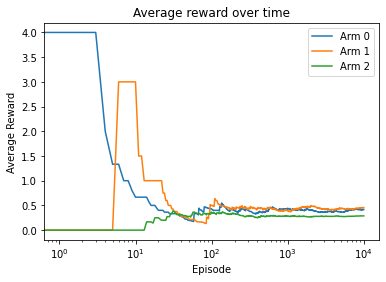

In [33]:
print(f"Average reward over {num_episodes} episodes: {sum(action_reward) / num_episodes}")
bandit_visual(num_actions, action_avg_reward)

## Epsilon-Greedy 
Solving the multi-armed bandit problem using the epsilon-greedy strategy. Saturates faster than the random policy. 

In [34]:
# Using the same presets

bandit_payout = [0.1, 0.15, 0.3]
bandit_reward = [4, 3, 1]
bandit_env = BanditEnv(bandit_payout, bandit_reward)

num_episodes = 10000
num_actions = len(bandit_payout)
action_count = [0 for i in range(num_actions)]
action_reward = [0 for i in range(num_actions)]
action_avg_reward = [[] for i in range(num_actions)]

In [35]:
# epsilon-greedy policy

def gen_eps_greedy_policy(num_actions, epsilon):
    def policy(Q):
        probs = torch.ones(num_actions) * epsilon / num_actions
        best_action = torch.argmax(Q).item()
        probs[best_action] = 1. - epsilon
        action = torch.multinomial(probs, 1).item()
        return action
    return policy

In [36]:
epsilon = 0.2
eps_policy = gen_eps_greedy_policy(num_actions, epsilon)
Q = torch.zeros(num_actions)

for episode in tqdm(range(num_episodes)):
    action = eps_policy(Q)
    reward = bandit_env.step(action)
    action_count[action] += 1
    action_reward[action] += reward
    Q[action] = action_reward[action] / action_count[action]
    # Visualizations
    for a in range(num_actions):
        if action_count[a] > 0:
            action_avg_reward[a].append(action_reward[a] / action_count[a])
        else:
            action_avg_reward[a].append(0)

100%|██████████| 10000/10000 [00:01<00:00, 5201.14it/s]


Average reward over 10000 episodes: 0.4477


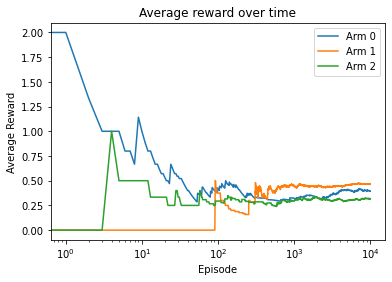

In [38]:
print(f"Average reward over {num_episodes} episodes: {sum(action_reward) / num_episodes}")
bandit_visual(num_actions, action_avg_reward)

## Softmax exploration
Solving the multi-armed bandit problem using the softmax distribution function. Higher the temperate tau, more the exploration.

In [51]:
# Using the same presets

bandit_payout = [0.1, 0.15, 0.3]
bandit_reward = [4, 3, 1]
bandit_env = BanditEnv(bandit_payout, bandit_reward)

num_episodes = 10000
num_actions = len(bandit_payout)
action_count = [0 for i in range(num_actions)]
action_reward = [0 for i in range(num_actions)]
action_avg_reward = [[] for i in range(num_actions)]

In [52]:
# Softmax policy

def gen_softmax_exploration_policy(tau):
    def policy(Q):
        probs = torch.exp(Q / tau)
        probs /= torch.sum(probs)
        action = torch.multinomial(probs, 1).item()
        return action
    return policy

In [53]:
tau = 0.1
softmax_policy = gen_softmax_exploration_policy(tau)
Q = torch.zeros(num_actions)

for episode in tqdm(range(num_episodes)):
    action = softmax_policy(Q)                 # Only difference
    reward = bandit_env.step(action)
    action_count[action] += 1
    action_reward[action] += reward
    Q[action] = action_reward[action] / action_count[action]
    # Visualizations
    for a in range(num_actions):
        if action_count[a] > 0:
            action_avg_reward[a].append(action_reward[a] / action_count[a])
        else:
            action_avg_reward[a].append(0)

100%|██████████| 10000/10000 [00:01<00:00, 5586.45it/s]


Average reward over 10000 episodes: 0.406


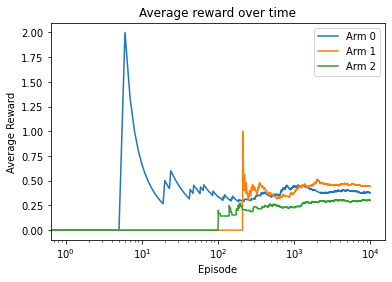

In [54]:
print(f"Average reward over {num_episodes} episodes: {sum(action_reward) / num_episodes}")
bandit_visual(num_actions, action_avg_reward)

## Upper Confidence Bound algorithm
The UCB algorithm uses the upper confidence bound to estimate the potential of the arm. The higher the UCB, the more likely the action is to be taken. Works better than or equal to eps-greedy.

In [60]:
# Presets
bandit_payout = [0.1, 0.15, 0.3]
bandit_reward = [4, 3, 1]
bandit_env = BanditEnv(bandit_payout, bandit_reward)

num_episodes = 10000
num_actions = len(bandit_payout)
action_count = torch.tensor([0 for i in range(num_actions)])      # Convert to Tensor
action_reward = [0 for i in range(num_actions)]
action_avg_reward = [[] for i in range(num_actions)]

In [61]:
# Upper confidence bound algorithm
def upper_confidence_bound(Q, action_count, t):
    # t -> episode number 
    ucb = torch.sqrt((2 * torch.log(torch.tensor(float(t)))) / action_count) + Q
    return torch.argmax(ucb).item() 

In [62]:
Q = torch.zeros(num_actions)

for episode in tqdm(range(num_episodes)):
    action = upper_confidence_bound(Q, action_count, episode)
    reward = bandit_env.step(action)
    action_count[action] += 1
    action_reward[action] += reward
    Q[action] = action_reward[action] / action_count[action]
    # Visualizations
    for a in range(num_actions):
        if action_count[a] > 0:
            action_avg_reward[a].append(action_reward[a] / action_count[a])
        else:
            action_avg_reward[a].append(0)

100%|██████████| 10000/10000 [00:03<00:00, 2661.53it/s]


Average reward over 10000 episodes: 0.4332


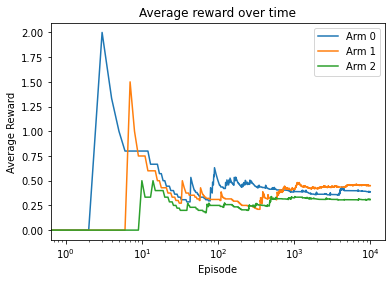

In [63]:
print(f"Average reward over {num_episodes} episodes: {sum(action_reward) / num_episodes}")
bandit_visual(num_actions, action_avg_reward)

## Internet Advertising - Multi-Armed Bandit
3 different colored ad background, 3 types of ad wording. Choose set that maximizes the clickthrough rate (CTR)
Reward - 1 if clicked, 0 otherwise.

Solved using the UCB algorithm

In [64]:
# Presets
bandit_payout = [0.01, 0.015, 0.03]      # CTR 1% for ad 1, 1.5% for ad 2 and 3% for ad 3
bandit_reward = [1, 1, 1]
bandit_env = BanditEnv(bandit_payout, bandit_reward)

num_episodes = 10000
num_actions = len(bandit_payout)
action_count = torch.tensor([0 for i in range(num_actions)])      # Convert to Tensor
action_reward = [0 for i in range(num_actions)]
action_avg_reward = [[] for i in range(num_actions)]

In [65]:
Q = torch.zeros(num_actions)

for episode in tqdm(range(num_episodes)):
    action = upper_confidence_bound(Q, action_count, episode)
    reward = bandit_env.step(action)
    action_count[action] += 1
    action_reward[action] += reward
    Q[action] = action_reward[action] / action_count[action]
    # Visualizations
    for a in range(num_actions):
        if action_count[a] > 0:
            action_avg_reward[a].append(action_reward[a] / action_count[a])
        else:
            action_avg_reward[a].append(0)

100%|██████████| 10000/10000 [00:04<00:00, 2049.25it/s]


Average reward over 10000 episodes: 0.02


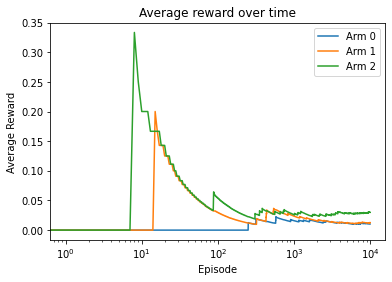

In [66]:
print(f"Average reward over {num_episodes} episodes: {sum(action_reward) / num_episodes}")
bandit_visual(num_actions, action_avg_reward)

## Thompson Sampling / Bayesian Bandits
- Probabilistic algorithm
- Computes prior probabilities of arms 
- Selects arm with highest probability and observes reward
- Updates prior distribution based on observed reward -> **Bayesian update**

Beta distribution used.

Higher the alpha value, the more the distribution is skewed towards 1, and higher the beta value the more the distribution is skewed towards 0.
beta(1, 1) is the bell curve.

In [11]:
# Presets
bandit_payout = [0.01, 0.015, 0.03]      # CTR 1% for ad 1, 1.5% for ad 2 and 3% for ad 3
bandit_reward = [1, 1, 1]
bandit_env = BanditEnv(bandit_payout, bandit_reward)

num_episodes = 10000
num_actions = len(bandit_payout)
action_count = torch.tensor([0 for i in range(num_actions)])      # Convert to Tensor
action_reward = [0 for i in range(num_actions)]
action_avg_reward = [[] for i in range(num_actions)]

In [12]:
# Thompson Sampling
def thompson_sampling(alpha, beta):
    prior_values = torch.distributions.beta.Beta(alpha, beta).sample()
    return torch.argmax(prior_values)

In [13]:
alpha = torch.ones(num_actions)
beta = torch.ones(num_actions)

In [14]:
for episode in tqdm(range(num_episodes)):
    action = thompson_sampling(alpha, beta)
    reward = bandit_env.step(action)
    action_count[action] += 1
    action_reward[action] += reward
    if reward > 0:
        alpha[action] += 1
    else:
        beta[action] += 1
    # Visualizations
    for a in range(num_actions):
        if action_count[a] > 0:
            action_avg_reward[a].append(action_reward[a] / action_count[a])
        else:
            action_avg_reward[a].append(0)

100%|██████████| 10000/10000 [00:06<00:00, 1512.90it/s]


Average reward over 10000 episodes: 0.0281


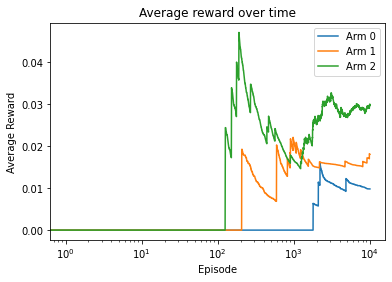

In [15]:
print(f"Average reward over {num_episodes} episodes: {sum(action_reward) / num_episodes}")
bandit_visual(num_actions, action_avg_reward)

## Internet Advertising - Contextual Bandits
Extends multi-armed bandits by introducing states. i.e. contextual bandits are a set of multi-armed bandits. 
Bandits have no delayed or discounted rewards. In between multi-arm bandits and MDPs. 

States are not determined by previous actions or events, but are simply observations of the environment.
Two machines used in this example.

In [23]:
bandit_payout_machines = [[0.01, 0.015, 0.03], [0.025, 0.01, 0.015]]
bandit_reward_machines = [[1, 1, 1], [1, 1, 1]]

# List of bandit environments
num_machines = len(bandit_payout_machines)
bandit_env_machines = [BanditEnv(payout, reward) for payout, reward in zip(bandit_payout_machines, bandit_reward_machines)]

In [24]:
num_episodes = 100000

# Add another dimension for the additional machines
num_actions = len(bandit_payout_machines[0])
action_count = torch.zeros(num_machines, num_actions)      # Convert to Tensor
action_reward = torch.zeros(num_machines, num_actions)
action_avg_reward = [[[] for i in range(num_actions)] for machine in range(num_machines)]

In [25]:
# Upper confidence bound algorithm
def upper_confidence_bound(Q, action_count, t):
    # t -> episode number 
    ucb = torch.sqrt((2 * torch.log(torch.tensor(float(t)))) / action_count) + Q
    return torch.argmax(ucb).item() 

In [26]:
Q_machines = torch.empty(num_machines, num_actions)


In [27]:
for episode in tqdm(range(num_episodes)):
    state = torch.randint(0, num_machines, (1,)).item()
    action = upper_confidence_bound(Q_machines[state], action_count[state], episode)
    reward = bandit_env_machines[state].step(action)
    action_count[state][action] += 1
    action_reward[state][action] += reward
    Q_machines[state][action] = action_reward[state][action] / action_count[state][action]
    for a in range(num_actions):
        if action_count[state][a] > 0:
            action_avg_reward[state][a].append(action_reward[state][a] / action_count[state][a])
        else:
            action_avg_reward[state].append(0)

100%|██████████| 100000/100000 [00:38<00:00, 2580.77it/s]


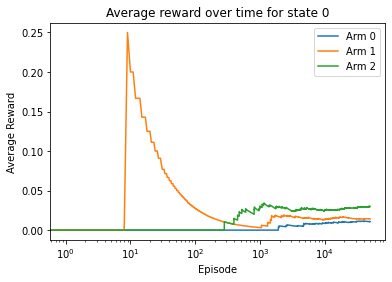

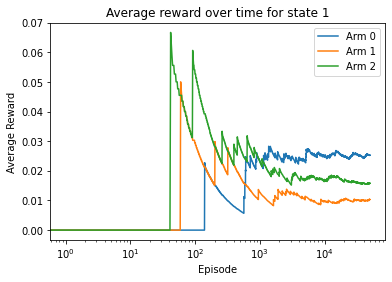

In [28]:
for state in range(num_machines):
    for action in range(num_actions):
        plt.plot(action_avg_reward[state][action])
    plt.legend(["Arm {}".format(action) for action in range(num_actions)])
    plt.title(f"Average reward over time for state {state}")
    plt.xscale('log')
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")
    plt.show()